In [1]:
import data.data_wrangling as dw

import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from pyspark.sql.functions import avg, count, udf, array

from pyspark.sql.functions import first

from pyspark.sql.functions import percent_rank

from pyspark.sql.window import Window

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
from pyspark import SparkContext

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest

import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from pyspark.sql.functions import avg

from pyspark.sql.functions import first

from pyspark.sql.functions import percent_rank

from pyspark.sql.window import Window

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
from pyspark import SparkContext

from mpl_toolkits import mplot3d
from statsmodels.graphics.mosaicplot import mosaic

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

from pyspark.sql.functions import avg

from pyspark.sql.functions import first

from pyspark.sql.functions import percent_rank

from pyspark.sql.window import Window

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
from pyspark import SparkContext

In [2]:
# import pip

# import sys
# import subprocess

# subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflow'])

# subprocess.check_call([sys.executable, '-m', 'pip', 'freeze'])

In [3]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


In [4]:
# Read in data and get column names

data = pd.read_csv('data/synthetic_income.csv')

data.shape

(22674, 14)

In [5]:
# data with outlier detection values

data_w_outlier_val = data.copy()

# outcome variable label

outcome = 'income'

# id column label

id_col = 'id'

# list of categorical columns

# obtained from kaggle website
cat_col = ['workclass', 'education',
           'marital-status', 'occupation', 
           'relationship',
           'race', 'sex', 
           'native-country', 'income']

# categorical columns without outcome variable

cat_col_wo_outcome = [col for col in cat_col if col != outcome]

# cat cols without outcome and two category values

cat_col_more_than_2 = list()
for col in cat_col:
    if data[col].nunique() > 2:
        cat_col_more_than_2.append(col)

cat_col_2_or_fewer = list(set(cat_col) - set(cat_col_more_than_2))

# list of non-id numeric columns

num_col = [col for col in data.columns if col not in cat_col and col != id_col]

In [6]:
# Convert categorical columns to "categorical" in pandas

data_with_cat = dw.convert_col_to_cat(data, cat_col)

data_with_cat.head()

,id,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Female,2174,6428,40,United-States,<=1000000
1,1,35,Self-emp-not-inc,Bachelors,Divorced,Exec-managerial,Other-relative,White,Female,0,5303,13,United-States,<=1000000
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Female,0,3923,40,United-States,<=1000000
3,3,24,Private,11th,Divorced,Handlers-cleaners,Other-relative,Black,Female,0,7979,40,United-States,<=1000000
4,4,28,Private,Bachelors,Divorced,Other-service,Wife,Black,Female,0,7880,40,Cuba,<=1000000


In [7]:
# equal width discretization of numeric columns

data_with_cat = dw.convert_num_to_obj(data_with_cat, num_col)

In [8]:
# Attribute value frequency

## read in pandas df as spark df

spark = SparkSession.builder.getOrCreate()

data_cat_only_spark_df = spark.createDataFrame(data_with_cat)

for column in data_cat_only_spark_df.columns:
    if column not in ['id', 'income']:
        data_cat_only_spark_df = data_cat_only_spark_df.withColumn(column, count(column).over(Window.partitionBy(column)))

avg_cols = udf(lambda array: sum(array)/len(array), DoubleType())

wanted_cols = [col for col in data_cat_only_spark_df.columns if col not in ['id', 'income']]

data_cat_only_spark_df_with_avf = data_cat_only_spark_df.withColumn("avf", avg_cols(array(*wanted_cols)))

# ## count frequency for each category

# def count_freq_for_cat(df):
#     counts_dict = dict()
#     for col in df.select_dtypes(['category']):
#         counts_dict[col] = df[col].value_counts().to_dict()
#     return counts_dict

# counts_dict = count_freq_for_cat(data_with_cat)

# ## use map in pandas

# def map_freq_to_value(df, counts_dict):
#     df_with_freq = pd.DataFrame()
#     for col in df:
#         if str(df[col].dtypes) == 'category' and col != outcome:
#             df_with_freq[col] = df[col].map(counts_dict[col])
#         else:
#             df_with_freq[col] = df[col]
#     return df_with_freq

# data_num_to_cat_with_freq = map_freq_to_value(data_with_cat, counts_dict)

# data_num_to_cat_with_freq.head()

# data_num_to_cat_with_freq['avf'] = data_num_to_cat_with_freq.drop(columns=[outcome, id_col]).apply(np.sum, axis=1) / 13

data_cat_only_pd_with_avf = data_cat_only_spark_df_with_avf.toPandas()

data_cat_only_pd_with_avf[['id', 'avf', outcome]].head()

,id,avf,income
0,20314,7235.166667,<=1000000
1,5063,7758.333333,<=1000000
2,13290,8518.833333,<=1000000
3,5592,9166.166667,<=1000000
4,8554,8423.083333,<=1000000


In [9]:
## add avf to data_w_outlier_val

data_w_outlier_val = data_w_outlier_val.merge(data_cat_only_pd_with_avf[['id', 'avf']], on='id')

In [10]:
# Local Outlier Factor

data_all_num = dw.convert_cat_to_numeric(data, cat_col_more_than_2, cat_col_2_or_fewer)

## drop unwanted variables

X = data_all_num.drop(columns=[outcome])

## fit predict local outlier factor

lof = LocalOutlierFactor(n_jobs=-1)

y_pred = lof.fit_predict(X.drop(columns=id_col))

len(lof.negative_outlier_factor_)

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


22674

In [11]:
lof.negative_outlier_factor_ * -1

## make copy of X dataframe

X_lof = X.copy()

## add lof values to X dataframe

X_lof['lof'] = lof.negative_outlier_factor_ * -1

X_lof.head()

,id,age,sex,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,lof
0,0,39,0,2174,6428,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.051334
1,1,35,0,0,5303,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.223342
2,2,38,0,0,3923,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0.987671
3,3,24,0,0,7979,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1.002332
4,4,28,0,0,7880,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.992838


In [12]:
## add lof to data_w_outlier_val

data_w_outlier_val = data_w_outlier_val.merge(X_lof[['id', 'lof']], on='id')

data_w_outlier_val.head(100)

,id,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,avf,lof
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Female,2174,6428,40,United-States,<=1000000,10776.750000,1.051334
1,1,35,Self-emp-not-inc,Bachelors,Divorced,Exec-managerial,Other-relative,White,Female,0,5303,13,United-States,<=1000000,10048.833333,1.223342
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Female,0,3923,40,United-States,<=1000000,12663.416667,0.987671
3,3,24,Private,11th,Divorced,Handlers-cleaners,Other-relative,Black,Female,0,7979,40,United-States,<=1000000,10675.666667,1.002332
4,4,28,Private,Bachelors,Divorced,Other-service,Wife,Black,Female,0,7880,40,Cuba,<=1000000,9000.833333,0.992838
5,5,37,Private,Masters,Divorced,Exec-managerial,Wife,White,Female,0,3576,40,United-States,<=1000000,11579.083333,0.948166
6,6,49,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,2672,16,Jamaica,<=1000000,6937.583333,1.672478
7,7,23,Private,Bachelors,Never-married,Adm-clerical,Own-child,White,Female,0,733,30,United-States,<=1000000,11098.083333,1.124065
8,8,32,Private,Assoc-acdm,Never-married,Sales,Not-in-family,Black,Female,0,1492,50,United-States,<=1000000,9783.666667,1.088148
9,9,34,Private,7th-8th,Divorced,Transport-moving,Other-relative,Amer-Indian-Eskimo,Female,0,8965,45,Mexico,<=1000000,8839.750000,0.988725


In [13]:
# one-class svm

## copy X dataframe to X_svm

X_svm = X.copy()

## standardize data for svm

X_standardized = dw.standardize_numeric_variables(X_svm.drop(columns=id_col), X_svm.columns[1:])

X_standardized.head()

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,age,sex,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.744678,-0.029713,0.087762,0.532543,0.048656,-0.161736,-0.262148,-1.932256,-0.029713,-0.292321,...,-0.036399,-0.065547,-0.019927,-0.050202,-0.031865,-0.024856,-0.026574,0.324905,-0.051077,-0.021005
1,0.292574,-0.029713,-0.036871,0.146088,-2.178272,-0.161736,-0.262148,-1.932256,-0.029713,3.420895,...,-0.036399,-0.065547,-0.019927,-0.050202,-0.031865,-0.024856,-0.026574,0.324905,-0.051077,-0.021005
2,0.631652,-0.029713,-0.036871,-0.327963,0.048656,-0.161736,-0.262148,0.517530,-0.029713,-0.292321,...,-0.036399,-0.065547,-0.019927,-0.050202,-0.031865,-0.024856,-0.026574,0.324905,-0.051077,-0.021005
3,-0.950711,-0.029713,-0.036871,1.065336,0.048656,-0.161736,-0.262148,0.517530,-0.029713,-0.292321,...,-0.036399,-0.065547,-0.019927,-0.050202,-0.031865,-0.024856,-0.026574,0.324905,-0.051077,-0.021005
4,-0.498607,-0.029713,-0.036871,1.031328,0.048656,-0.161736,-0.262148,0.517530,-0.029713,-0.292321,...,-0.036399,-0.065547,-0.019927,-0.050202,-0.031865,-0.024856,-0.026574,-3.077821,-0.051077,-0.021005


In [14]:
## instantiate svm class

clf = svm.OneClassSVM()

## fit the data

clf.fit(X_standardized)

## get the predicted values

X_svm['svm'] = clf.decision_function(X_standardized)

# add svm results to data_w_outlier_val

data_w_outlier_val = data_w_outlier_val.merge(X_svm[['id', 'svm']], on='id')

data_w_outlier_val.head(100)

,id,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,avf,lof,svm
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Female,2174,6428,40,United-States,<=1000000,10776.750000,1.051334,-157.655392
1,1,35,Self-emp-not-inc,Bachelors,Divorced,Exec-managerial,Other-relative,White,Female,0,5303,13,United-States,<=1000000,10048.833333,1.223342,-81.128904
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Female,0,3923,40,United-States,<=1000000,12663.416667,0.987671,405.689030
3,3,24,Private,11th,Divorced,Handlers-cleaners,Other-relative,Black,Female,0,7979,40,United-States,<=1000000,10675.666667,1.002332,-539.211629
4,4,28,Private,Bachelors,Divorced,Other-service,Wife,Black,Female,0,7880,40,Cuba,<=1000000,9000.833333,0.992838,-3250.629227
5,5,37,Private,Masters,Divorced,Exec-managerial,Wife,White,Female,0,3576,40,United-States,<=1000000,11579.083333,0.948166,-898.860784
6,6,49,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,2672,16,Jamaica,<=1000000,6937.583333,1.672478,-3302.916662
7,7,23,Private,Bachelors,Never-married,Adm-clerical,Own-child,White,Female,0,733,30,United-States,<=1000000,11098.083333,1.124065,399.258294
8,8,32,Private,Assoc-acdm,Never-married,Sales,Not-in-family,Black,Female,0,1492,50,United-States,<=1000000,9783.666667,1.088148,-507.477968
9,9,34,Private,7th-8th,Divorced,Transport-moving,Other-relative,Amer-Indian-Eskimo,Female,0,8965,45,Mexico,<=1000000,8839.750000,0.988725,-2675.627431


# isolation forest

In [24]:
X_standardized.shape

clf = IsolationForest(n_jobs=-1, max_features=10, n_estimators=1000, max_samples=1000)
clf.fit(X_standardized)

# predictions
y_pred_train = clf.predict(X_standardized)

data_w_outlier_val['iforest'] = clf.decision_function(X_standardized)

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


### The anomaly score of the input samples. The lower, the more abnormal. Negative scores represent outliers, positive scores represent inliers.

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
W0729 12:14:45.960287 140676557104960 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 12:14:45.977528 140676557104960 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 12:14:45.981892 140676557104960 dep

Train on 22674 samples, validate on 22674 samples
Epoch 1/100
22674/22674 [==============================] - 1s 55us/step - loss: 0.9791 - acc: 0.1804 - val_loss: 0.9407 - val_acc: 0.2561
Epoch 2/100
22674/22674 [==============================] - 1s 62us/step - loss: 0.9167 - acc: 0.3333 - val_loss: 0.8969 - val_acc: 0.3852
Epoch 3/100
22674/22674 [==============================] - 1s 64us/step - loss: 0.8848 - acc: 0.4148 - val_loss: 0.8737 - val_acc: 0.4418
Epoch 4/100
22674/22674 [==============================] - 1s 41us/step - loss: 0.8653 - acc: 0.4517 - val_loss: 0.8566 - val_acc: 0.4607
Epoch 5/100
22674/22674 [==============================] - 1s 40us/step - loss: 0.8500 - acc: 0.4659 - val_loss: 0.8429 - val_acc: 0.4734
Epoch 6/100
22674/22674 [==============================] - 1s 40us/step - loss: 0.8375 - acc: 0.4770 - val_loss: 0.8314 - val_acc: 0.4840
Epoch 7/100
22674/22674 [==============================] - 1s 41us/step - loss: 0.8275 - acc: 0.4894 - val_loss: 0.8222 - 

22674/22674 [==============================] - 1s 39us/step - loss: 0.6812 - acc: 0.5950 - val_loss: 0.6797 - val_acc: 0.5939
Epoch 60/100
22674/22674 [==============================] - 1s 38us/step - loss: 0.6795 - acc: 0.5960 - val_loss: 0.6776 - val_acc: 0.5851
Epoch 61/100
22674/22674 [==============================] - 1s 38us/step - loss: 0.6777 - acc: 0.5970 - val_loss: 0.6764 - val_acc: 0.6039
Epoch 62/100
22674/22674 [==============================] - 1s 38us/step - loss: 0.6762 - acc: 0.5975 - val_loss: 0.6748 - val_acc: 0.6014
Epoch 63/100
22674/22674 [==============================] - 1s 37us/step - loss: 0.6746 - acc: 0.5961 - val_loss: 0.6730 - val_acc: 0.6014
Epoch 64/100
22674/22674 [==============================] - 1s 38us/step - loss: 0.6729 - acc: 0.5959 - val_loss: 0.6715 - val_acc: 0.5976
Epoch 65/100
22674/22674 [==============================] - 1s 38us/step - loss: 0.6715 - acc: 0.5967 - val_loss: 0.6701 - val_acc: 0.5972
Epoch 66/100
22674/22674 [==============

/home/daniel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


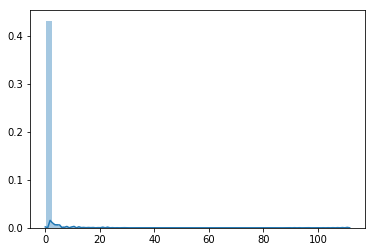

In [16]:
# autoencoder

data_all_num = dw.convert_cat_to_numeric(data, cat_col_more_than_2, cat_col_2_or_fewer)

num_data_standardized = dw.standardize_numeric_variables(data_all_num, data_all_num.columns)

X_train = num_data_standardized.drop(columns=['id', 'income'])

input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train, X_train),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

autoencoder = load_model('model.h5')

predictions = autoencoder.predict(X_train)

mse = np.mean(np.power(X_train - predictions, 2), axis=1)

sns.distplot(mse)

In [17]:
mse.describe()

count    22674.000000
mean         0.619855
std          3.193865
min          0.041288
25%          0.119994
50%          0.195312
75%          0.373153
max        111.531527
dtype: float64

In [18]:
data_w_outlier_val['autoencoder'] = mse

# Anomaly Detection Scores

In [26]:
def color(s):
    row_color_list = list()

    # avf
    if s.avf < 1000:
        row_color_list.extend(['background-color: red'])
    elif s.avf >= 1000 and s.avf < 1200:
        row_color_list.extend(['background-color: yellow'])
    elif s.avf >= 1200:
        row_color_list.extend(['background-color: green'])

    # lof
    if s.lof <= 1.05:
        row_color_list.extend(['background-color: green'])
    elif s.lof > 1.05 and s.lof < 1.3:
        row_color_list.extend(['background-color: yellow'])
    elif s.lof >= 1.3:
        row_color_list.extend(['background-color: red'])

    # svm
    if s.svm < -100:
        row_color_list.extend(['background-color: red'])
    elif s.svm >= -100 and s.svm < 100:
        row_color_list.extend(['background-color: yellow'])
    elif s.svm >= 100:
        row_color_list.extend(['background-color: green'])

    # iforest
    if s.iforest < 0:
        row_color_list.extend(['background-color: red'])
    elif s.iforest >= 0 and s.iforest < 0.1:
        row_color_list.extend(['background-color: yellow'])
    elif s.iforest >= 0.1:
        row_color_list.extend(['background-color: green'])

    # autoencoder
    if s.autoencoder > 0.396917:
        row_color_list.extend(['background-color: red'])
    elif s.autoencoder <= 0.396917 and s.autoencoder > 0.206993:
        row_color_list.extend(['background-color: yellow'])
    elif s.autoencoder <= 0.206993:
        row_color_list.extend(['background-color: green'])

    return row_color_list

result_df = data_w_outlier_val.loc[:, ['id', 'income', 'avf', 'lof', 'svm', 'iforest', 'autoencoder']]

result_df_style = result_df.sort_values(by='income',
                                        ascending=False).iloc[:1000, :1000].style.apply(color,
                                                                                        subset=['avf',
                                                                                               'lof',
                                                                                               'svm',
                                                                                               'iforest',
                                                                                               'autoencoder'],
                                                                                        axis=1)

result_df_style

# 3d plots

<IPython.core.display.Javascript object>


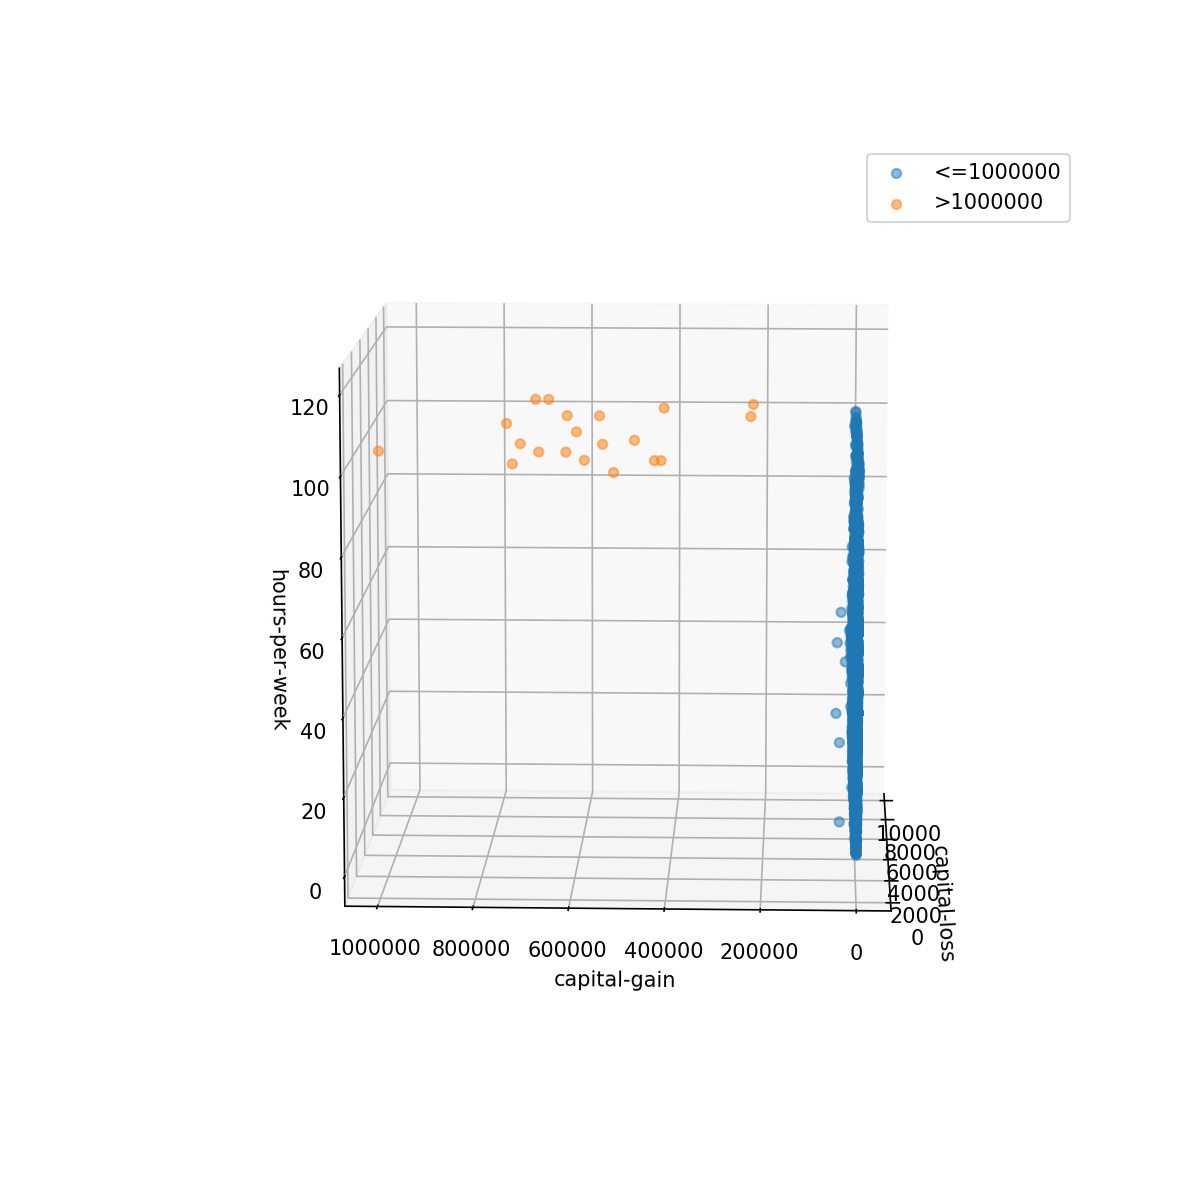

In [28]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = data_all_num.loc[data_all_num[outcome] == 0, 'hours-per-week']
xdata = data_all_num.loc[data_all_num[outcome] == 0, 'capital-loss']
ydata = data_all_num.loc[data_all_num[outcome] == 0, 'capital-gain']
ax.scatter3D(xdata, ydata, zdata, cmap=data_all_num[outcome], label='<=1000000', alpha=0.5)
zdata = data_all_num.loc[data_all_num[outcome] == 1, 'hours-per-week']
xdata = data_all_num.loc[data_all_num[outcome] == 1, 'capital-loss']
ydata = data_all_num.loc[data_all_num[outcome] == 1, 'capital-gain']
ax.scatter3D(xdata, ydata, zdata, cmap=data_all_num[outcome], label='>1000000', alpha=0.5)
ax.set_xlabel('capital-loss')
ax.set_ylabel('capital-gain')
ax.set_zlabel('hours-per-week')
ax.legend()

<IPython.core.display.Javascript object>


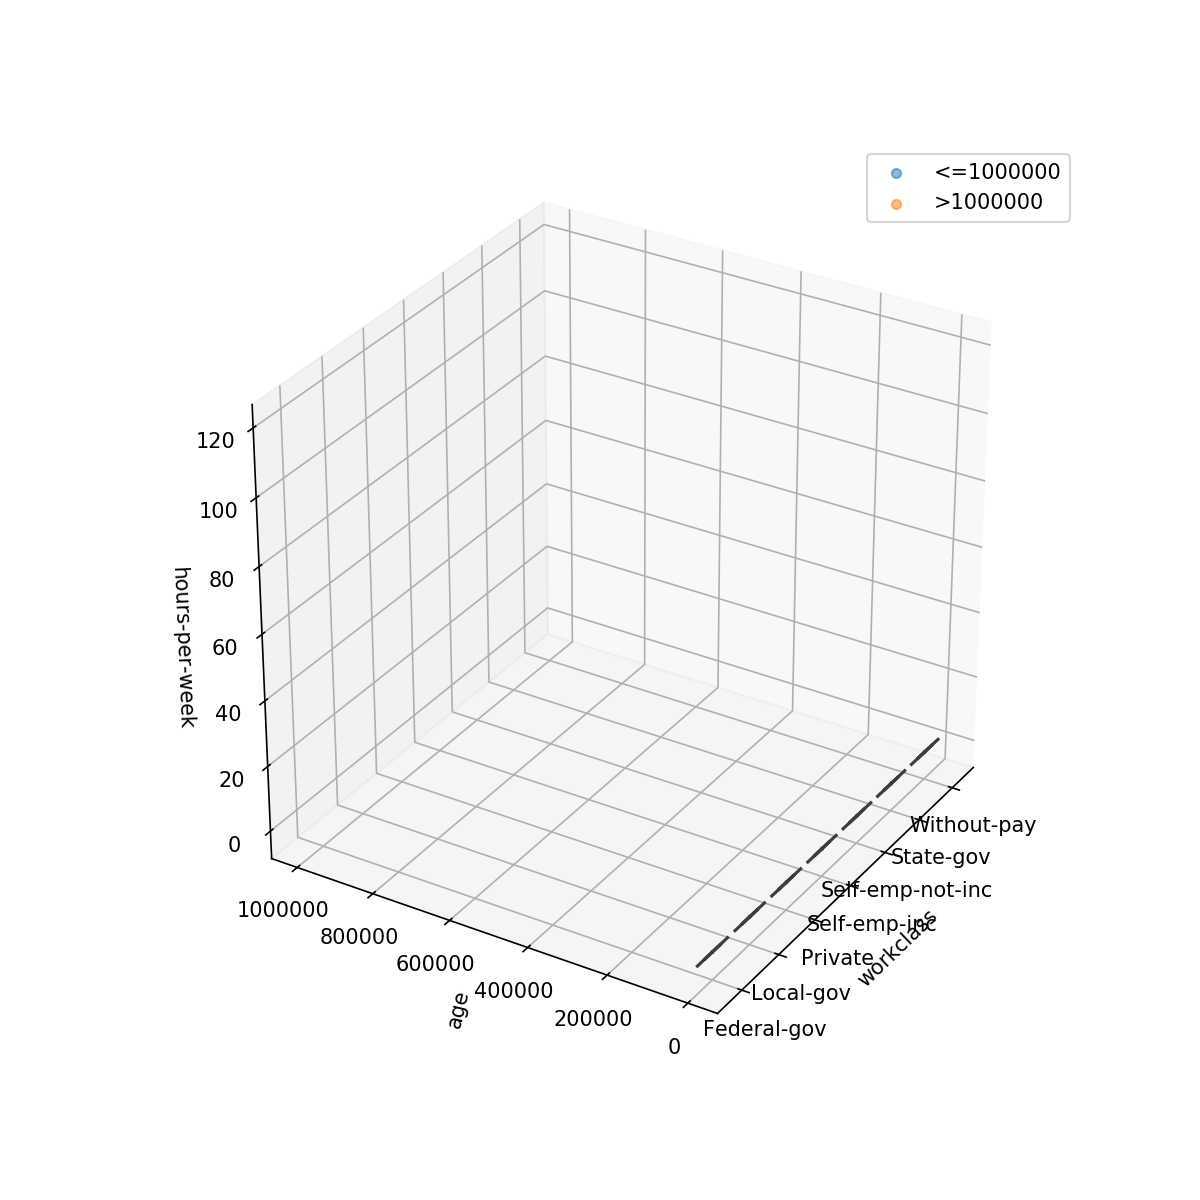

In [29]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = data_all_num.loc[data_all_num[outcome] == 0, 'hours-per-week']
xdata = data_all_num.loc[data_all_num[outcome] == 0, 'age']
ydata = data_all_num.loc[data_all_num[outcome] == 0, 'capital-gain']
ax.scatter3D(xdata, ydata, zdata, cmap=data_all_num[outcome], label='<=1000000', alpha=0.5)
zdata = data_all_num.loc[data_all_num[outcome] == 1, 'hours-per-week']
xdata = data_all_num.loc[data_all_num[outcome] == 1, 'age']
ydata = data_all_num.loc[data_all_num[outcome] == 1, 'capital-gain']
ax.scatter3D(xdata, ydata, zdata, cmap=data_all_num[outcome], label='>1000000', alpha=0.5)
ax.set_xlabel('age')
ax.set_ylabel('capital-gain')
ax.set_zlabel('hours-per-week')
ax.legend()

# generalized pairs plot

In [30]:
data_cat_and_num = dw.convert_col_to_cat(data, cat_col)

data_cat_and_num.dtypes

data_cat_and_num.drop(columns='id', inplace=True)

data_cat_num_subset = data_cat_and_num[['age', 'workclass', 'education', 'occupation', 'capital-gain']]

col_names = data_cat_num_subset.columns

import itertools
col_pairs = [col for col in itertools.product(col_names, repeat=2)]

In [31]:
col_pairs

[('age', 'age'),
 ('age', 'workclass'),
 ('age', 'education'),
 ('age', 'occupation'),
 ('age', 'capital-gain'),
 ('workclass', 'age'),
 ('workclass', 'workclass'),
 ('workclass', 'education'),
 ('workclass', 'occupation'),
 ('workclass', 'capital-gain'),
 ('education', 'age'),
 ('education', 'workclass'),
 ('education', 'education'),
 ('education', 'occupation'),
 ('education', 'capital-gain'),
 ('occupation', 'age'),
 ('occupation', 'workclass'),
 ('occupation', 'education'),
 ('occupation', 'occupation'),
 ('occupation', 'capital-gain'),
 ('capital-gain', 'age'),
 ('capital-gain', 'workclass'),
 ('capital-gain', 'education'),
 ('capital-gain', 'occupation'),
 ('capital-gain', 'capital-gain')]

<IPython.core.display.Javascript object>


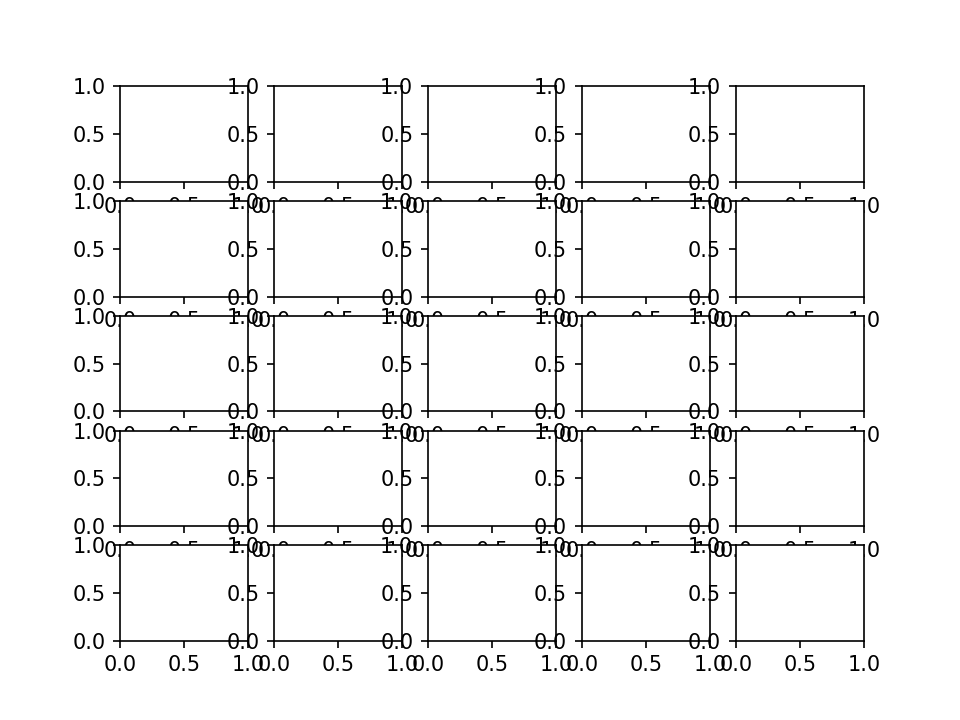

['int64', 'int64']
['int64', 'category']
['int64', 'category']
['int64', 'category']
['int64', 'int64']
['category', 'int64']
['category', 'category']
['category', 'category']
['category', 'category']
['category', 'int64']
['category', 'int64']
['category', 'category']
['category', 'category']
['category', 'category']
['category', 'int64']
['category', 'int64']
['category', 'category']
['category', 'category']
['category', 'category']
['category', 'int64']
['int64', 'int64']
['int64', 'category']
['int64', 'category']
['int64', 'category']
['int64', 'int64']


In [32]:
count = 0
fig, axes = plt.subplots(nrows=5, ncols=5)
for i, ax_row in enumerate(axes):
    for j, ax_col in enumerate(axes):
        pair = col_pairs[count]
        dtype_pair = list()
        dtype_pair.append(str(data_cat_num_subset[pair[0]].dtypes))
        dtype_pair.append(str(data_cat_num_subset[pair[1]].dtypes))
        print(dtype_pair)
        count += 1

sns.boxplot(x='workclass',y='age',data=data_cat_and_num.loc[:, ['workclass', 'age']], ax=ax)
fig.show()

<IPython.core.display.Javascript object>


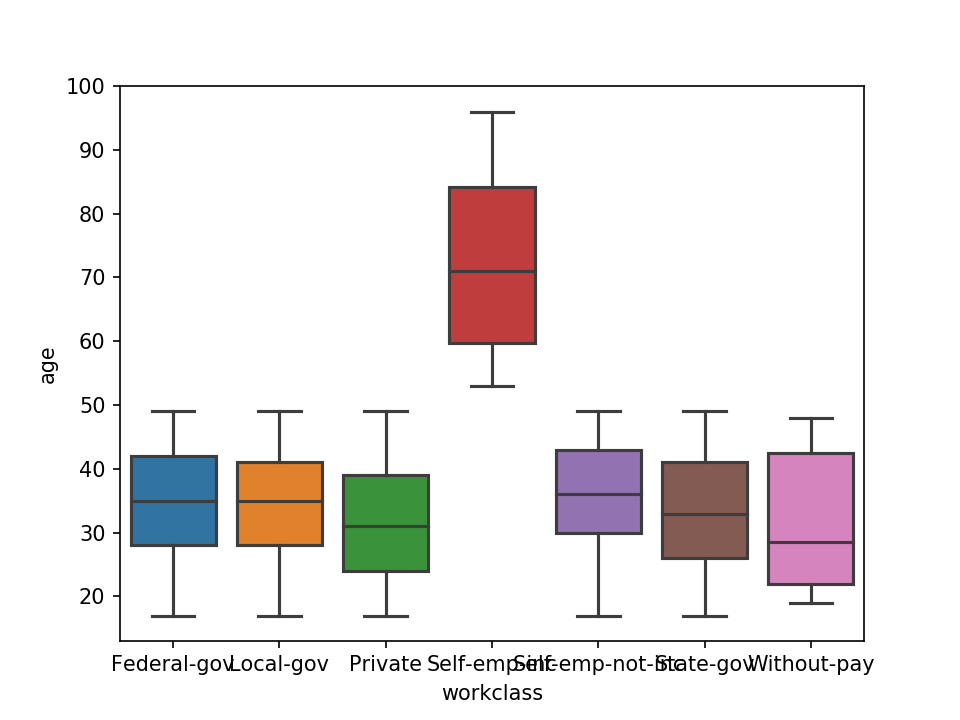

In [33]:
fig, ax = plt.subplots()
sns.boxplot(x='workclass',y='age',data=data_cat_and_num.loc[:, ['workclass', 'age']], ax=ax)
fig.show()

<IPython.core.display.Javascript object>


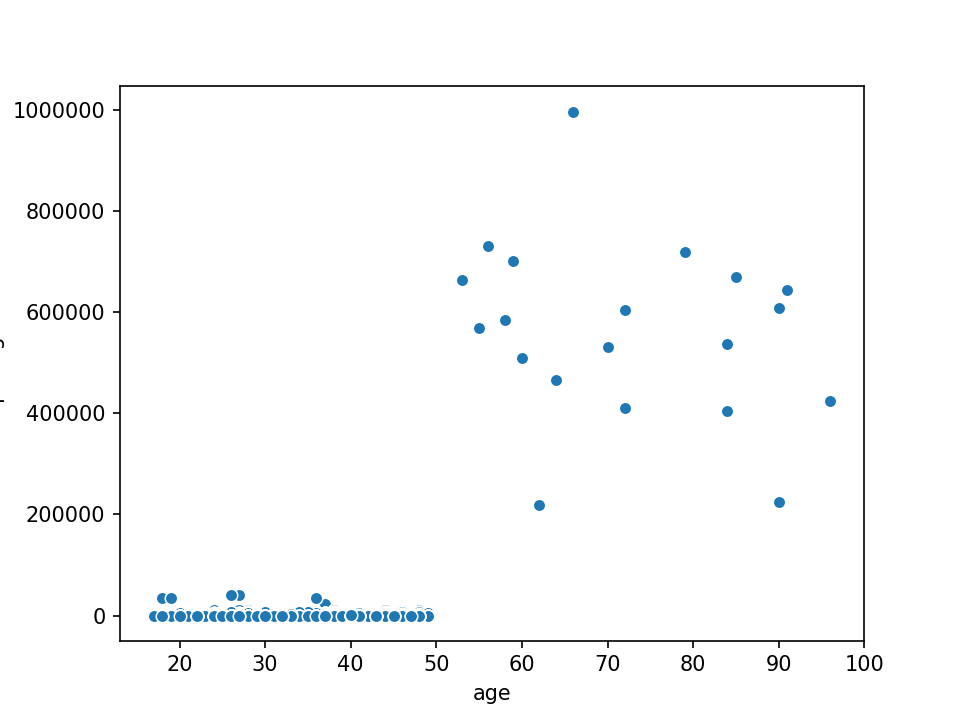

In [34]:
fig, ax = plt.subplots()
sns.scatterplot(x='age',y='capital-gain',data=data_cat_and_num, ax=ax)
fig.show()

<IPython.core.display.Javascript object>


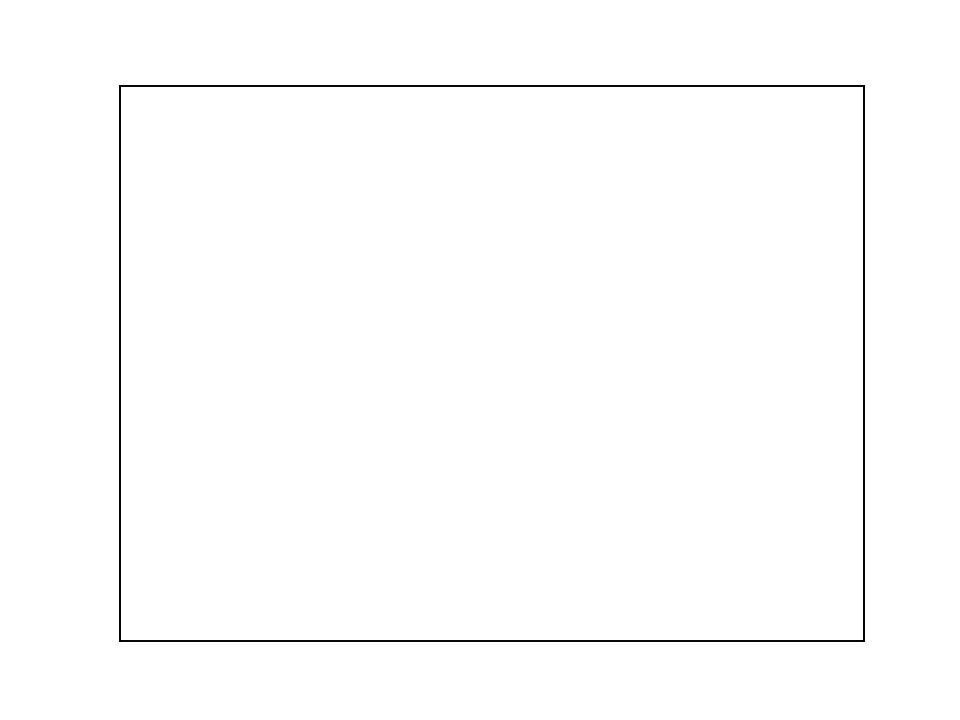

/home/daniel/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/mosaicplot.py:40: RuntimeWarning: invalid value encountered in less
  if np.any(proportion < 0):


In [35]:
fig, ax = plt.subplots()
mosaic(data_cat_and_num, ['education', 'marital-status'], ax=ax, labelizer = lambda x: "")
fig.show()

<IPython.core.display.Javascript object>


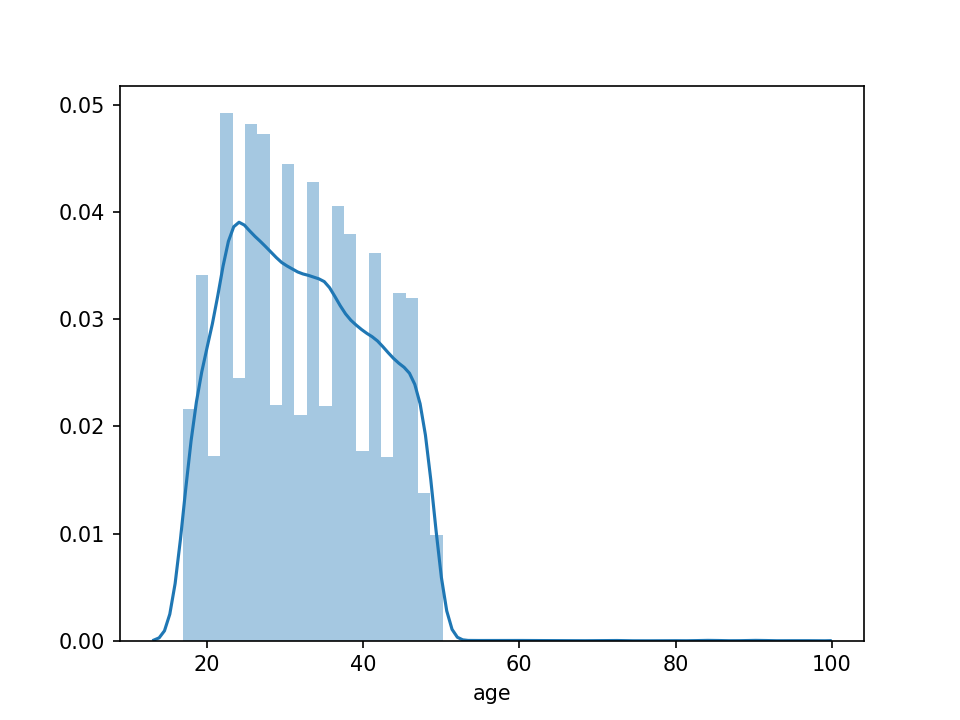

/home/daniel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [36]:
fig, ax = plt.subplots()
sns.distplot(a=data_cat_and_num['age'],  ax=ax)
fig.show()

<IPython.core.display.Javascript object>


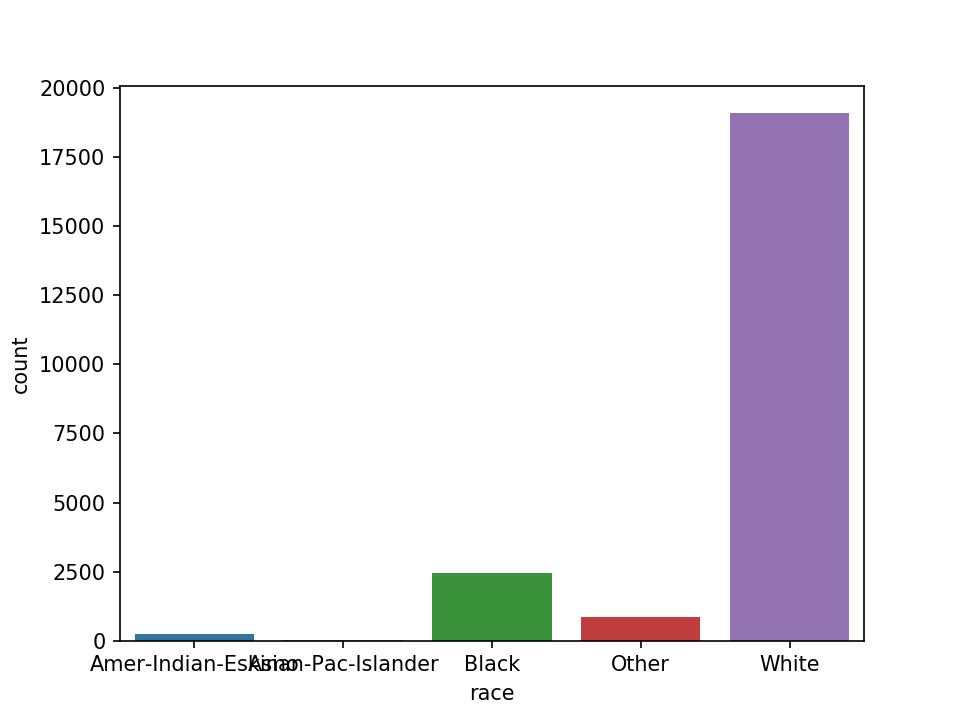

In [37]:
fig, ax = plt.subplots()
sns.countplot(x='race', data=data_cat_and_num,  ax=ax)
fig.show()